# GAN

### Why study generative modeling?
- Be incorporated into reinforcement learning.
    -  A generative model used for planning can learn a conditional distribution over future states of the world, given the current state of the world and hypothetical actions an agent might take as input. The agent can query the model with different potential actions and choose actions that the model predicts are likely to yield a desired state of the world.
    - The agent can learn in an **imaginary environment**, where mistaken actions do not cause real damage to the agent.
- To represent high-dimensional probability distribution.
    - A data, say an image, can be viewed as **a data sampled from a high dimensional distribution**. For our model GAN, we want to train a generator that can **represent a high-dimensional probability distribution**.
- To generate images for fun.

### Framework
There are two roles in GAN: **generator** and **discriminator**, which are usually neural networks. Let $\mathcal{X}$ be the space of images and $\mathcal{Z}$ be the disribution of the input noise. $\mathcal{Z}$ is called the latent space as well.
- Generator:
  - The counterfeiter trying to make fake currency
  - A differentiable function $G:\mathcal{Z}\to\mathcal{X}$ that inputs a latent vector and output a fake sample
- Discriminator
  - The police, trying to allow legitimate money and catch counterfeit money
  - A differentiable function $D:\mathcal{X}\to[0,1]$ that inputs a fake or real sample and outputs the probability that the sample is **real**

Their interaction can be illustrated as below:
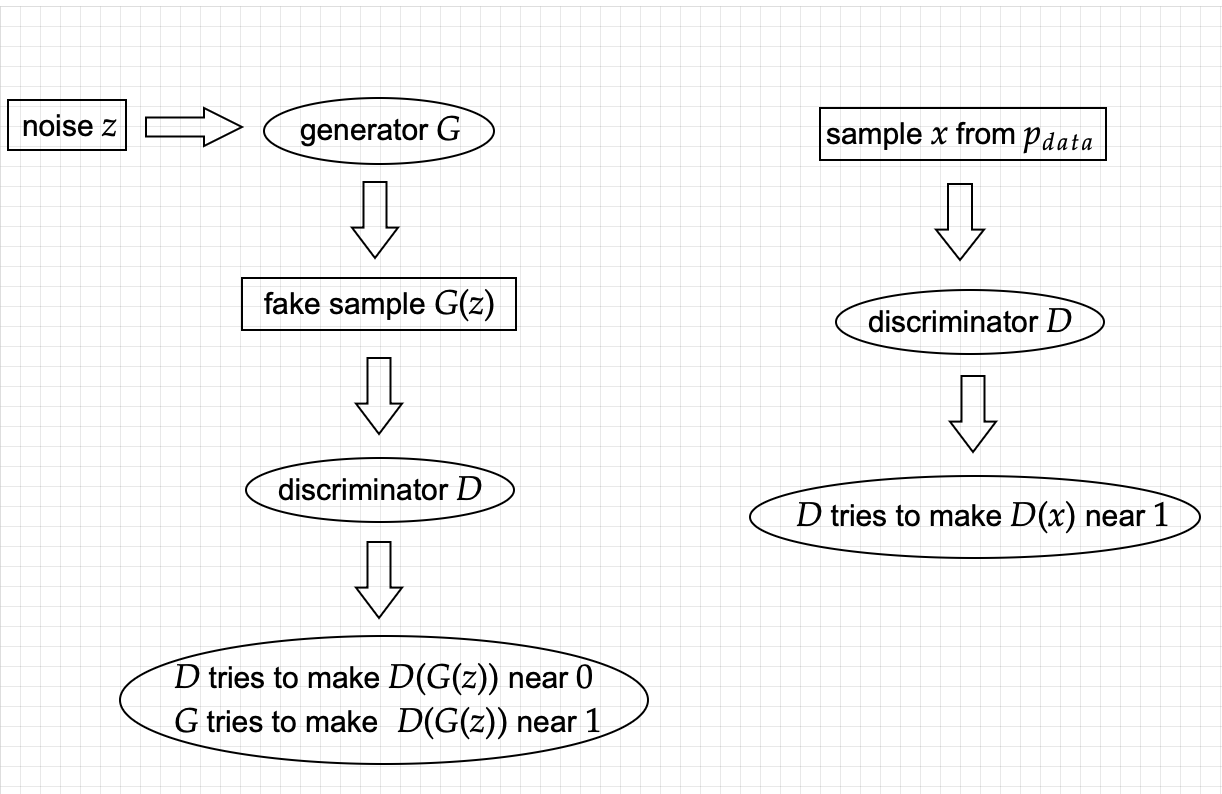



### Vanilla GAN (using MLP)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

### Loss Functions
Designing the loss functions of generator and discriminator is a critical part of GAN. The inappropriate choice of loss functions would make the convergence of GAN much more difficult.

Let $\theta^G$ and $\theta^D$ be the parameters of generator and discriminator. Let $L_G(\theta^G,\theta^D)$ and $L_D( \theta^G,\theta^D)$ be the loss functions of generator and discriminator. An interesting fact is that all of the different games designed for GANs so far use the same cost for
the discriminator, $L_D$. They differ only in terms of the cost used for the
generator, $L_G$. (Ian Goodfellow, 2016)

The loss of discriminator usually defined as
$$
L_D(\theta^D,\theta^G) = -\mathbb{E}_{x\sim \mathbb{P}_{data}} \log D(x) -\mathbb{E}_z \log (1-D(G(z))).
$$
- $\log$: avoid long precision
- $D(x)$: the probability that $x$ is real
- $1-D(G(z))$: the probaility that $D$ tells $z$ is fake, i.e. $D$ is not deceived by $G$
- If the probability is close to 1, then the loss is small.

**Remark**: One could observe that the design of the loss function matches the goal of the discriminator: $D$ tries to make $D(x)\to 1$ and $D(G(z_i))\to 0$.


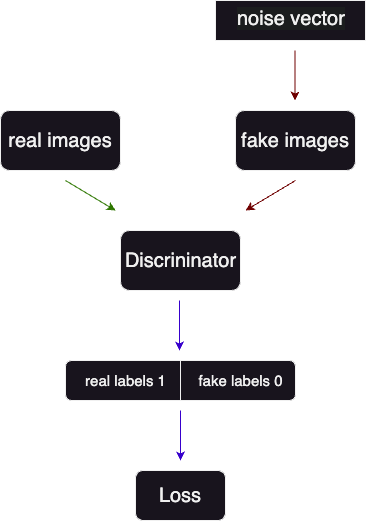

In practice, we use (Binary Cross Entropy) `nn.BCELoss()` as our loss function. It measures the (binary) cross entropy between the target and the input probabilities.
$$
-\frac{1}{n}\left(\sum_{i=1}^n y_i\ln x_i+(1-y_i)\ln(1-x_i)\right)
$$
You might see other people use `BCEWithLogitsLoss`, which is basically `BCELoss(Sigmoid(x))` where `x` is the model output. In general, the sigmoid function is used for the two-class logistic regression which outputs a value between 0 and 1. We indeed need sigmoid here since the output layer of `Discriminator` is `Linear`,ranging from $-\infty$ to $\infty$, which is not a probability. You can add `nn.Sigmoid` after `Linear` and  use `BCELoss` or

`BCEWithLogitsLoss` looks like
$$
-\frac{1}{n}\left(\sum_{i=1}^n y_i\ln \sigma(x_i)+(1-y_i)\ln(1-\sigma(x_i))\right).
$$
We choose `nn.BCELoss()` since we've added `nn.Sigmoid()` to our discriminator.

In [ ]:
Loss = nn.BCELoss()

In [ ]:
real_labels = torch.ones(batch_imgs.size()[0],1)
fake_labels = torch.zeros(batch_imgs.size()[0],1)

In [ ]:
def TrainD():
    ...
    real_loss = Loss(real_out.squeeze(), real_labels)
    fake_loss = Loss(fake_out.squeeze(), fake_labels)
    total_loss = real_loss+fake_loss
    ...

GAN itself is a zero-sum game. Thus, we'll naturally define $L_G$ as
$$
L_G=-L_D.
$$
In this case, we can describe GAN by $V(\theta^G,\theta^D)=-L_D(\theta^G,\theta^D)$, and the optimal generator is thus
$$
\theta^{G^*}=\arg\min_{\theta^G}\max_{\theta^D} V(\theta^G,\theta^D).
$$
However, if we define the loss of $G$ in this way, we may encounter gradient vanishing. In the beginning of training, the generator is poor and the discriminator can tell fake samples easily, resulting in small gradient. The generator cannot improve efficiently, and the training of GAN may be very slow.

Recall that **the gradient points to the maximum of the function**. With this in mind, we can use another equivalent loss:
$$
L_G=-\mathbb{E}_z[\log D(G(z))].
$$
$G(z)$ is the probability that $D$ is deceived, believing that $G(z)$ is a real sample. When $D$ can tell fake samples with high confidence (high probability), then the probability $D(G(z))$ is small and the loss $L_G$ is large. The gradient is also larger than before if $G$ is poor.


In [ ]:
def TrainG():
    ...
    g_loss = Loss(d_out.squeeze(), real_labels)
    ...

### Training
The general training algorithm is below. We update the discriminator with fixed generator, and update the generator with fixed discriminator.
#### General training algorithm
Initialize $\theta^D,\theta^G$

**for** each training iteration **do**

$\quad$ **for** $K$ steps **do**

$\quad\quad$ Update the discriminator parameters $\theta^D$ using the gradient $\nabla_{\theta^D} L_D(\theta^D,\theta^G)$

$\quad$ **end for**

$\quad$ Update the discriminator parameters $\theta^G$ using the gradient $\nabla_{\theta^G} L_D(\theta^D,\theta^G)$

**end for**
 

We have to calucate the gradient of loss to update our parameters. However, it's intractable to calculate the expectation. It would be simpler if we can **take the gradient first and then take the expectation**. This operation is achievable and the idea can start from this famous calculus theorem:

**Theorem (Leibnitz integral rule)** If $a(x),b(x),f(x,y)$ are $C^1$, then
$$
\frac{d}{dx}\int_{a(x)}^{b(x)} f(x,y)dy=f(x,b(x))b'(x)-f(x,a(x))a'(x)+\int_{a(x)}^{b(x)} \frac{\partial }{\partial x}f(x,y)dy.
$$
If $a(x),b(x)$ are constant, then
$$
\frac{d}{dx}\int_{a}^{b} f(x,y)dy=\int_{a}^{b}\frac{\partial }{\partial x}f(x,y)dy.
$$
Expectation is an integral. We could expect that we can replace $y$ by a random variable $Y$ under some conditions. Indeed, such theorem exists.

**Theorem** Let $X$ be a random variable, $g\colon \mathbb{R}\times\Omega\longrightarrow \mathbb{R}$ a function such that $g(x,Y)$ is integrable for all $x$ and $g$ is continuously differentiable w.r.t. $x$. Assume that there is a random variable $Z$ such that $\frac{\partial}{\partial x}g(x,Y)\leq Z$ a.s. for all $x$ and $\mathbb{E}Z<\infty$. Then
$$
\frac{d}{dx}\mathbb{E}[g(x,X)]=\mathbb{E}[\frac{\partial}{\partial x}g(x,X)].
$$
You can replace $x$ by parameters $\theta$. There's a more general theorem with similar form of the conditions, but we're not going to mention it.

Thus, we have
$$
\begin{aligned}
    \nabla L_{D}(\theta^{D},\theta^{D}) & = \nabla\left(-\frac{1}{2}\mathbb{E}_{x\sim \mathbb{P}_{data}} \log D(x) -\frac{1}{2}\mathbb{E}_z \log (1-D(G(z)))\right) \\
    & = -\frac{1}{2}\mathbb{E}_{x\sim \mathbb{P}_{data}} \nabla\log D(x)-\frac{1}{2}\mathbb{E}_z \nabla\log (1-D(G(z)))
\end{aligned}
$$
and
$$
\begin{aligned}
    \nabla L_{G} & = \nabla\left(-\frac{1}{2}\mathbb{E}_z \log D(G(z))\right)\\
    & = -\frac{1}{2}\mathbb{E}_z \nabla\log D(G(z))
\end{aligned}
$$
$\nabla \log D(x)$ and $\nabla \log D(G(z))$ can be calculated with **backpropagation**, and each expectation can be estimated using **Monte Carlo estimation**.


#### Algorithm

Initialize $\theta^D,\theta^G$

**for** each training iteration **do**

$\quad$**for** $K$ steps **do**

$\quad\quad$ Sample batch of $m$ noise vectors $z_i$ 

$\quad\quad$ Sample batch of $m$ examples $x_i$ 

$\quad\quad$ Update the discriminator by performing stochastic gradient descent using
$$
\nabla_{\theta^D}\frac{1}{m}\sum_{i=1}^m\left[-\log D(x_i)-\log (1-D(G(z_i)))\right]
$$
**end for**

$\quad$ Sample batch of $m$ noise vectors $z_i$

$\quad$ Update the generator by performing stochastic gradient descent using
$$
\nabla_{\theta^G}\frac{1}{m}\sum_{i=1}^m\left[-\log D(G(z_i))\right]
$$
**end for**


In [ ]:
# Train the discriminator
# Sample from generator
noise_vectors = torch.randn(batch_imgs.size(0), 100)
fake_imgs = generator(noise_vectors)
fake_labels = torch.zeros(batch_imgs.size(0))

d_loss = TrainD(discriminator, batch_imgs, real_labels, fake_imgs, fake_labels)

# Train generator
# Sample from generator
noise_vectors = torch.randn(batch_imgs.size(0), 100)
fake_imgs = generator(noise_vectors)
outputs = discriminator(fake_imgs)

g_loss = TrainG(generator, outputs, real_labels)

## PyTorch implementation
We implement the vannila GAN with MLP.

### Import modules

In [35]:
import itertools
import math

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

### Set configuration

In [60]:
config = {
    'lr':0.0002,
    'n_epoch':300,
    'batch_size':100,
}

### Set seed

In [63]:
def same_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seed(0)

### Set device

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Load Dataset

In [6]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100.0%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


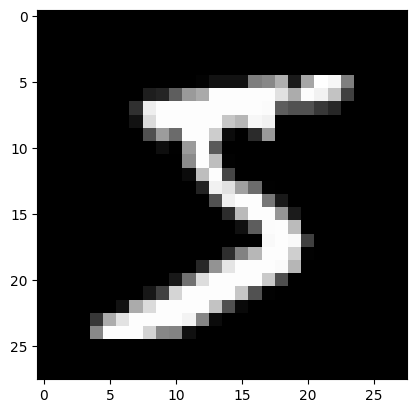

In [ ]:
sample_img = train_dataset.train_data.numpy()[0]
plt.imshow(sample_img,cmap='gray')

### Model

In [65]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [66]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [67]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

Discriminator loss:
- When passing a real training image, the output values are compared with 1 (for real images) and real loss is calculated.
- When passing latent vector to the generator, a fake image is generated and passed to the discriminator, and the outputs are compared with 0 (for fake images) and fake loss is calculated.

Generator loss:
- Since the generator wants to fool the discriminator, the output labels are compared with 1 (for supposedly real images) and loss is calculated.

### Loss and optimizers

In [68]:
Loss = nn.BCELoss()

People usually choose `Adam` to be the optimizer of GAN.

In [69]:
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['lr'] ,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=config['lr'] ,betas=(0.5,0.999))

### Training

In [70]:
def TrainD(discriminator, images, real_labels, fake_images, fake_labels):
    # Zero the gradient
    discriminator.zero_grad()
    real_out = discriminator(images)
    real_loss = Loss(real_out.squeeze(), real_labels)

    fake_out = discriminator(fake_images)
    fake_loss = Loss(fake_out.squeeze(), fake_labels)

    d_loss = real_loss + fake_loss

    # Backpropagation
    d_loss.backward()
    # Update the model parameters
    d_optimizer.step()
    return d_loss

In [71]:
def TrainG(generator, d_out, real_labels):
    # Zero the gradient
    generator.zero_grad()
    g_loss = Loss(d_out.squeeze(), real_labels)

    # Backpropagation
    g_loss.backward()
    # Update the model parameters
    g_optimizer.step()
    return g_loss

In [72]:
# Draw samples from the input distribution to inspect the generation on training
fixed_number_samples = 16
fixed_noise = Variable(torch.randn(fixed_number_samples, 100)).to(device)

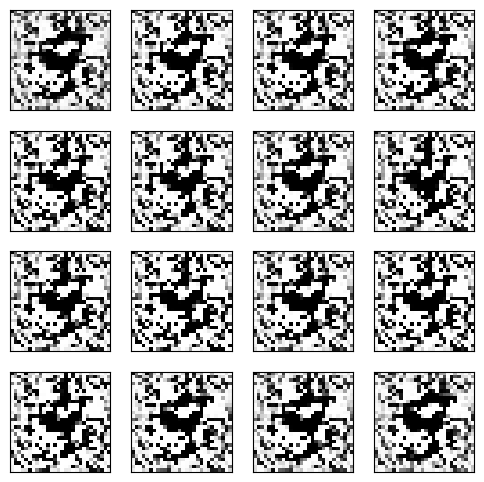

epoch: 299
d_loss: tensor(9.2017e-07, device='cuda:0', grad_fn=<AddBackward0>) g_loss: tensor(81.4070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


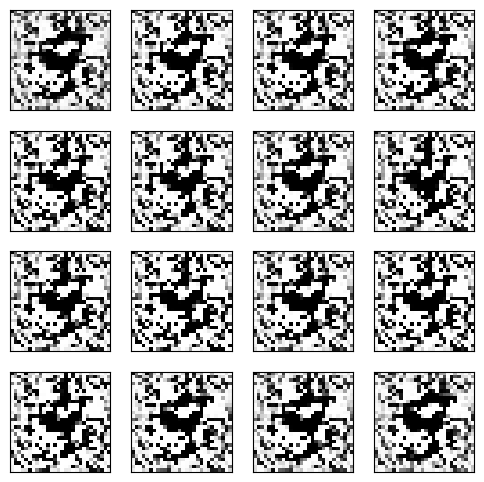

In [73]:
# Create figure for plotting
size_figure_grid = int(math.sqrt(fixed_number_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

for epoch in range(config['n_epoch']):
    for n, (batch_imgs, _) in enumerate(train_loader):
        batch_imgs = batch_imgs.cuda()
        real_labels = torch.ones(batch_imgs.size(0)).to(device)

        # Train the discriminator
        # Sample from generator
        noise_vectors = torch.randn(batch_imgs.size(0), 100).to(device)
        fake_imgs = generator(noise_vectors)
        fake_labels = torch.zeros(batch_imgs.size(0)).to(device)

        d_loss = TrainD(discriminator, batch_imgs, real_labels, fake_imgs, fake_labels)

        # Train generator
        # Sample from generator
        noise_vectors = torch.randn(batch_imgs.size(0), 100).to(device)
        fake_imgs = generator(noise_vectors).to(device)
        outputs = discriminator(fake_imgs).to(device)

        g_loss = TrainG(generator, outputs, real_labels)

        if (n+1) % 100 == 0:
            test_images = generator(fixed_noise)

            for k in range(fixed_number_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print('epoch:',epoch)
            print('d_loss:',d_loss,'g_loss:',g_loss)

### Observation
If you run this model yourself, you'll see that the generator seems to "oscillate"; that is; the loss of the generator goes up and down frequently, and even if the loss decreases, the generated images do not necessarily improve. Sometimes the images look real, and sometimes they look like noises. It takes long time to obtain a good result.

## References
- Generative Adversarial Networks, https://arxiv.org/abs/1406.2661
- NIPS 2016 Tutorial: Generative Adversarial Networks, https://arxiv.org/abs/1701.00160
- Probabilistic Machine Learning: Advanced Topics, https://probml.github.io/pml-book/book2.html
- https://www.kaggle.com/code/tjac718/dcgan-on-mnist-dataset-using-pytorch